In [4]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-
"""
Created on Mon Sep 25 23:51:15 2023

@author: mabso
"""


'\nCreated on Mon Sep 25 23:51:15 2023\n\n@author: mabso\n'

In [1]:
# packages read all below
import geopandas as gpd
import pandas as pd
import numpy as np
from sentinelhub import SHConfig
from sentinelhub.geometry import BBox, Geometry
from shapely.geometry import Polygon, mapping, MultiPolygon
import shutil
import glob
import datetime
import os
import tifffile as tiff
import json
import matplotlib.pyplot as plt
from sentinelhub import CRS, BBox, DataCollection, MimeType, WcsRequest, WmsRequest
import rasterio
import re

from sentinelhub import (
    CRS,
    BBox,
    DataCollection,
    DownloadRequest,
    MimeType,
    MosaickingOrder,
    SentinelHubDownloadClient,
    SentinelHubRequest,
    bbox_to_dimensions,
)



# Set the buffer size to 10000 MB (in bytes)
buffer_size = 1024 * 1024 * 10000

os.environ['ZLIB_BUF_SIZE'] = str(buffer_size)

In [3]:
# set up using your sentinelhub account

# Set your API credentials
CLIENT_ID = "b1e819d9-2c92-4aa3-88f7-08e6a55f3fdf"
CLIENT_SECRET = "Gx8L3VEUAWFDab6ZrJQY7Cn8IJp2ARyH"

# Configure Sentinel Hub
config = SHConfig()
config.sh_client_id = CLIENT_ID
config.sh_client_secret = CLIENT_SECRET

In [4]:
# read in your data

# read in shape files (id number and geometrics shape - lon and lat coordinate pairs)
file_path="LUCAS_2018_Copernicus/LUCAS_2018_Copernicus_polygons.shp"
df_shape=gpd.read_file(file_path)

# read in the soil file (id number and lots of soil properties per id number)
df_soil=pd.read_csv("LUCAS_2018_Copernicus/LUCAS-SOIL-2018.csv")
df_crop=df_soil[df_soil["LC"]=="B11"]

In [5]:

# set your evalscripts

# this is a float ndvi script - you can also compute these manually from raw data
evalscript_all_CI = """
   //VERSION=3
    function setup() {
      return{
        input: [{
          bands: ["B06", "B07"]
        }],
        output: {
          id: "default",
          bands: 1,
          sampleType: SampleType.FLOAT32
        }
      }
    }
    function evaluatePixel(sample) {
      let ndvi = ((sample.B07 ) / (sample.B06 )) - 1
      return [ ndvi ]
    }
"""
evalscript_all_nvdi = """
   //VERSION=3
    function setup() {
      return{
        input: [{
          bands: ["B04", "B08"]
        }],
        output: {
          id: "default",
          bands: 1,
          sampleType: SampleType.FLOAT32
        }
      }
    }
    function evaluatePixel(sample) {
      let ndvi = (sample.B08 - sample.B04) / (sample.B08 + sample.B04)
      return [ ndvi ]
    }
"""

evalscript_all_ndmi = """
   //VERSION=3
    function setup() {
      return{
        input: [{
          bands: ["B11", "B08"]
        }],
        output: {
          id: "default",
          bands: 1,
          sampleType: SampleType.FLOAT32
        }
      }
    }
    function evaluatePixel(sample) {
      let ndmi = (sample.B08 - sample.B11) / (sample.B08 + sample.B11)
      return [ ndmi ]
    }
"""

evalscript_all_MSAVI = """
   //VERSION=3
    function setup() {
      return {
        input: [{
          bands: ["B04", "B08"] // Red and Near-Infrared bands (Sentinel-2)
        }],
        output: {
          id: "default",
          bands: 1,
          sampleType: SampleType.FLOAT32
        }
      };
    }
    function evaluatePixel(sample) {
      const nir = sample.B08; // Near-Infrared band
      const red = sample.B04; // Red band

      // Calculate MSAVI
      const msavi = (2 * nir + 1 - Math.sqrt(Math.pow(2 * nir + 1, 2) - 8 * (nir - red))) / 2;

      return [msavi];
    }
"""


# this is the screen classifcation map
evalscript_complex="""
//VERSION=3

 function RGBToColor (r, g, b,dataMask){
	return [r/255, g/255, b/255,dataMask];
}

function setup() {
   return {
    input: ["SCL","dataMask"],
    output: { bands: 4 }
  };
}

function evaluatePixel(samples) {
    const SCL=samples.SCL;
    switch (SCL) {
    // No Data (Missing data) - black   
    case 0: return RGBToColor (0, 0, 0,samples.dataMask);
        
    // Saturated or defective pixel - red 
    case 1: return RGBToColor (255, 0, 0,samples.dataMask);

    // Topographic casted shadows ("Dark features/Shadows" for data before 2022-01-25) - very dark grey
    case 2: return RGBToColor (47,  47,  47,samples.dataMask);
        
    // Cloud shadows - dark brown
    case 3: return RGBToColor (100, 50, 0,samples.dataMask);
        
    // Vegetation - green
    case 4: return RGBToColor (0, 160, 0,samples.dataMask);
        
    // Not-vegetated - dark yellow
    case 5: return RGBToColor (255, 230, 90,samples.dataMask);
        
    // Water (dark and bright) - blue
    case 6: return RGBToColor (0, 0, 255,samples.dataMask);
    
    // Unclassified - dark grey
    case 7: return RGBToColor (128, 128, 128,samples.dataMask);
    
    // Cloud medium probability - grey
    case 8: return RGBToColor (192, 192, 192,samples.dataMask);
        
    // Cloud high probability - white
    case 9: return RGBToColor (255, 255, 255,samples.dataMask);
    
    // Thin cirrus - very bright blue
    case 10: return RGBToColor (100, 200, 255,samples.dataMask);
        
    // Snow or ice - very bright pink
    case 11: return RGBToColor (255, 150, 255,samples.dataMask);

    default : return RGBToColor (0, 0, 0,samples.dataMask);  
    }
}
"""

evalscript_EVI = """
  //VERSION=3
  function setup() {
      return {
          input: ["B02", "B04", "B08"],
          output: {
              bands: 1,
              sampleType: "FLOAT32"
          }
      };
  }

  function evaluatePixel(samples) {
      return [2.5 * (samples.B08 - samples.B04) / ((samples.B08 + 6.0 * samples.B04 - 7.5 * samples.B02) + 1.0)]
  }
"""
evalscript_NDMI2 = """
  //VERSION=3
  function setup() {
      return {
          input: ["B8A", "B11"],
          output: { bands: 1, sampleType: "FLOAT32" }
      };
  }

  function evaluatePixel(samples) {
      return [index(samples.B8A, samples.B11)];
  }

"""


In [6]:
# sampling month script
def samp_month_fun(mon_num):
    
    if mon_num=='01':
        out="2018-01-01", "2018-01-31"
    
    elif mon_num=='02':
        out="2018-02-01", "2018-02-28"
        
    elif mon_num=='03':
         out="2018-03-01", "2018-03-31"
    
    elif mon_num=='04':
        out="2018-04-01", "2018-04-30"
    
    elif mon_num=='05':
        out="2018-05-01", "2018-05-31"
    
    elif mon_num=='06':
        out="2018-06-01", "2018-06-30"
    
    elif mon_num=='07':
        out="2018-07-01", "2018-07-31"
    
    elif mon_num=='08':
        out="2018-08-01", "2018-08-31"
    
    elif mon_num=='09':
        out="2018-09-01", "2018-09-30"
    
    elif mon_num=='10':
        out="2018-10-01", "2018-10-31"
    
    elif mon_num=='11':
        out="2018-11-01", "2018-11-30"
        
    elif mon_num=='12':
        out="2018-12-01", "2018-12-31"
    
    return out

In [10]:
#download part of the script
# convert shape file data to int
df_shape["POINT_ID"]=df_shape["POINT_ID"].astype(int)
print(df_shape["POINT_ID"])
# it might be a good idea to choose only the ids that are associated with crops instead of downloading everything like i have
# so match these two: 
df_crop=df_soil[df_soil["LC"]=="B11"]

# idx=np.where(df_soil["LC0_Desc"]=="Cropland")[0] # index of crops
# crop_ids=np.array(df_soil.iloc[idx]["POINTID"]) # point ids which matches the df_shape
c=0

# set i from 0 to how ever many shapes files there are (you might need to do multiple downloads sessions if your account runs out)
for i in range(1521,1556):
    df_crop = df_crop.reset_index(drop=True)
    # get soil id
    crop_id=df_crop["POINTID"][i]
    samp_date=df_crop["SURVEY_DATE"][i]
    
    # extract polygon and match id name
    col_idx=np.where(df_shape["POINT_ID"]==crop_id)[0]
    id_name=df_shape.iloc[col_idx]['POINT_ID']
    
    # Check if col_idx is empty (length is 0)
    if len(col_idx) == 0:
    # Skip this iteration and move to the next
        continue
    
    polygon_str = df_shape['geometry'][col_idx]
    
    coords_list = []
    
    for polygon in df_shape['geometry'][col_idx]:
        # Extract the exterior coordinates of the polygon
        exterior_coords = list(polygon.exterior.coords)
    
        # Append the exterior coordinates to the list
        coords_list.append(exterior_coords)
    
    polygon = Polygon(coords_list[0])
    
    # Convert the Polygon into a MultiPolygon with a single polygon
    multi_polygon = MultiPolygon([polygon])
    
    # Convert the MultiPolygon to GeoJSON format
    geojson_data = json.dumps(mapping(multi_polygon))
    
    multi_polygon_geometry = json.loads(geojson_data) 
    
    
    dates=samp_month_fun(samp_date[3]+samp_date[4])
    end=dates[1]
    start=dates[0]
    
    end = end.split('-')
    year = int(end[0])
    month = int(end[1])
    day = int(end[2])
    import datetime
    end=datetime.datetime(year, month, day)
    
    start = start.split('-')
    year = int(start[0])
    month = int(start[1])
    day = int(start[2])
    
    start=datetime.datetime(year, month, day)
    
    n_chunks=30
    tdelta = (end - start) / n_chunks
    edges = [(start + i * tdelta).date().isoformat() for i in range(n_chunks)]
    #slots = [(edges[i], edges[i + 1]) for i in range(len(edges) - 1)]
    slots = [(edges[i], edges[i]) for i in range(len(edges) - 1)]
    #print(slots)

    # first evalscript to download from

    def get_NDWI_request(time_interval):
        return SentinelHubRequest(
            evalscript=evalscript_all_nvdi, # set your evalscript to what you want
            data_folder="sat_download", # change to where you want your data output
            input_data=[
                SentinelHubRequest.input_data(
                    data_collection=DataCollection.SENTINEL2_L2A,
                    time_interval=time_interval,
                    mosaicking_order=MosaickingOrder.LEAST_CC,
                    other_args={'processing': {'upsampling': 'BILINEAR', 'downsampling':'BILINEAR'}},
                    maxcc=0.2 # maxium cloud cover
                )
            ],
            responses=[SentinelHubRequest.output_response("default", MimeType.TIFF)],
            bbox=None,
            geometry=Geometry(multi_polygon_geometry, CRS.WGS84),
            size=(256, 256 ),  # Adjust the size of image as needed
            config=config,
        )
    
    def get_MSAVI_request(time_interval):
        return SentinelHubRequest(
            evalscript=evalscript_all_MSAVI, # set your evalscript to what you want
            data_folder="sat_download", # change to where you want your data output
            input_data=[
                SentinelHubRequest.input_data(
                    data_collection=DataCollection.SENTINEL2_L2A,
                    time_interval=time_interval,
                    mosaicking_order=MosaickingOrder.LEAST_CC,
                    other_args={'processing': {'upsampling': 'BILINEAR', 'downsampling':'BILINEAR'}},
                    maxcc=0.2 # maxium cloud cover
                )
            ],
            responses=[SentinelHubRequest.output_response("default", MimeType.TIFF)],
            bbox=None,
            geometry=Geometry(multi_polygon_geometry, CRS.WGS84),
            size=(256, 256 ),  # Adjust the size of image as needed
            config=config,
        )
    
    # second evalscript to download from (optional)

    def get_complex_request(time_interval):
        return SentinelHubRequest(
            evalscript=evalscript_complex, # set your second evalscript to what you want
            data_folder="sat_download", # change to where you want your data output
            input_data=[
                SentinelHubRequest.input_data(
                    data_collection=DataCollection.SENTINEL2_L2A,
                    time_interval=time_interval,
                    mosaicking_order=MosaickingOrder.LEAST_CC,
                    other_args={'processing': {'upsampling': 'BILINEAR', 'downsampling':'BILINEAR'}},
                    maxcc=0.2
                )
            ],
            responses=[SentinelHubRequest.output_response("default", MimeType.TIFF)],
            bbox=None,
            geometry=Geometry(multi_polygon_geometry, CRS.WGS84),
            size=(256, 256),  # Adjust the size as needed
            config=config,
        )
    
    def get_CI_request(time_interval):
        return SentinelHubRequest(
            evalscript=evalscript_all_CI, # set your second evalscript to what you want
            data_folder="sat_download", # change to where you want your data output
            input_data=[
                SentinelHubRequest.input_data(
                    data_collection=DataCollection.SENTINEL2_L2A,
                    time_interval=time_interval,
                    mosaicking_order=MosaickingOrder.LEAST_CC,
                    other_args={'processing': {'upsampling': 'BILINEAR', 'downsampling':'BILINEAR'}},
                    maxcc=0.2
                )
            ],
            responses=[SentinelHubRequest.output_response("default", MimeType.TIFF)],
            bbox=None,
            geometry=Geometry(multi_polygon_geometry, CRS.WGS84),
            size=(256, 256),  # Adjust the size as needed
            config=config,
        )
    
    def get_NDMI2_request(time_interval):
        return SentinelHubRequest(
            evalscript=evalscript_NDMI2, # set your second evalscript to what you want
            data_folder="sat_download", # change to where you want your data output
            input_data=[
                SentinelHubRequest.input_data(
                    data_collection=DataCollection.SENTINEL2_L2A,
                    time_interval=time_interval,
                    mosaicking_order=MosaickingOrder.LEAST_CC,
                    other_args={'processing': {'upsampling': 'BILINEAR', 'downsampling':'BILINEAR'}},
                    maxcc=0.2
                )
            ],
            responses=[SentinelHubRequest.output_response("default", MimeType.TIFF)],
            bbox=None,
            geometry=Geometry(multi_polygon_geometry, CRS.WGS84),
            size=(256, 256),  # Adjust the size as needed
            config=config,
        )
    
    def get_EVI_request(time_interval):
        return SentinelHubRequest(
            evalscript=evalscript_EVI, # set your second evalscript to what you want
            data_folder="sat_download", # change to where you want your data output
            input_data=[
                SentinelHubRequest.input_data(
                    data_collection=DataCollection.SENTINEL2_L2A,
                    time_interval=time_interval,
                    mosaicking_order=MosaickingOrder.LEAST_CC,
                    other_args={'processing': {'upsampling': 'BILINEAR', 'downsampling':'BILINEAR'}},
                    maxcc=0.2
                )
            ],
            responses=[SentinelHubRequest.output_response("default", MimeType.TIFF)],
            bbox=None,
            geometry=Geometry(multi_polygon_geometry, CRS.WGS84),
            size=(256, 256),  # Adjust the size as needed
            config=config,
        )
    
    def get_NDMI_request(time_interval):
        return SentinelHubRequest(
            evalscript=evalscript_all_ndmi, # set your second evalscript to what you want
            data_folder="sat_download", # change to where you want your data output
            input_data=[
                SentinelHubRequest.input_data(
                    data_collection=DataCollection.SENTINEL2_L2A,
                    time_interval=time_interval,
                    mosaicking_order=MosaickingOrder.LEAST_CC,
                    other_args={'processing': {'upsampling': 'BILINEAR', 'downsampling':'BILINEAR'}},
                    maxcc=0.2
                )
            ],
            responses=[SentinelHubRequest.output_response("default", MimeType.TIFF)],
            bbox=None,
            geometry=Geometry(multi_polygon_geometry, CRS.WGS84),
            size=(256, 256),  # Adjust the size as needed
            config=config,
        )
    
    # Create a list of requests
    list_of_requests = [
        get_NDMI2_request(slot) for slot in slots
    ] + [
        get_complex_request(slot) for slot in slots  # remove one of these if only wanting to download one thing at at time - usally a good idea to download multiple to speed up
    ]
    
    list_of_requests = [request.download_list[0] for request in list_of_requests]

  
    # Download data with multiple threads
    data = SentinelHubDownloadClient(config=config).download(list_of_requests, max_threads=5)
    
    # note if you only choose to download one at a time you may need to do some major editing down below
    
    # remove all files with blanks
    
    def are_all_pixels_zero(image):
        return np.all(image == 0)
    
    def process_folder(folder_path):
        subfolders_to_delete = []
        for root, subfolders, files in os.walk(folder_path):
            images_have_only_zeros = True
            for file in files:
                if file.lower().endswith('.tiff'):
                    image_path = os.path.join(root, file)
                    image = tiff.imread(image_path)
                    if not are_all_pixels_zero(image):
                        images_have_only_zeros = False
                        break
            
            if images_have_only_zeros and root != folder_path:
                subfolders_to_delete.append(root)
    
        for subfolder in subfolders_to_delete:
            print(f"Deleting subfolder: {subfolder}")
            # Uncomment the line below to actually delete the subfolder and its contents
            #shutil.rmtree(subfolder)
            
        return subfolders_to_delete
    if __name__ == "__main__":
        root_folder = "sat_download"
        XX=process_folder(root_folder)
        ''
    for i in range(1,len(XX)):
        print(i)
        shutil.rmtree(XX[i])
        
    # move files

    
    def process_folder(folder_path):
        image_dict = {}  # To store matching image and mask paths
    
        for root, _, files in os.walk(folder_path):
            for file in files:
                if file.lower().endswith('.json'):
                    json_path = os.path.join(root, file)
                    with open(json_path) as json_file:
                        json_data = json.load(json_file)
    
                    start_time = json_data["request"]["payload"]["input"]["data"][0]["dataFilter"]["timeRange"]["from"]
                    end_time = json_data["request"]["payload"]["input"]["data"][0]["dataFilter"]["timeRange"]["to"]
                    
                    for tiff_file in files:
                        if tiff_file.lower().endswith('.tiff') or tiff_file.lower().endswith('.tif'):
                            tiff_path = os.path.join(root, tiff_file)
                            image_dict.setdefault(start_time, []).append(tiff_path)
    
        for start_time, files in image_dict.items():
            if len(files) == 2:
                image_path = max(files, key=lambda x: os.path.getsize(x))
                mask_path = min(files, key=lambda x: os.path.getsize(x))
                from datetime import datetime
                # Convert start_time to a more filesystem-friendly format
                start_time_dt = datetime.strptime(start_time, "%Y-%m-%dT%H:%M:%SZ")
                formatted_start_time = start_time_dt.strftime("%Y-%m-%d_%H-%M-%S")
                
                target_subfolder = os.path.join(folder_path, formatted_start_time)
                os.makedirs(target_subfolder, exist_ok=True)
                
                # Rename and move the image and mask files
                sr_image_path = os.path.join(target_subfolder, "sr.tiff") # name of first file
                scl_mask_path = os.path.join(target_subfolder, "scl.tiff") # name of second files
                shutil.move(image_path, sr_image_path)
                shutil.move(mask_path, scl_mask_path)
    
                print(f"Transferred to subfolder: {target_subfolder}")
                
                # Delete the original subfolder
                #   shutil.rmtree(os.path.dirname(image_path))
                
        print("Processing completed.")
    
    if __name__ == "__main__":
        root_folder = "sat_download" # set to your root folder
        process_folder(root_folder)
    
    # remove all non date time files
    from datetime import datetime
    
    def is_datetime_format(string, format):
        try:
            datetime.strptime(string, format)
            return True
        except ValueError:
            return False
    
    def delete_non_datetime_folders(root_folder):
        for folder in os.listdir(root_folder):
            folder_path = os.path.join(root_folder, folder)
            if os.path.isdir(folder_path) and not is_datetime_format(folder, "%Y-%m-%d_%H-%M-%S"):
                print(f"Deleting folder: {folder_path}")
                # Uncomment the line below to actually delete the folder and its contents
                shutil.rmtree(folder_path)
    
    if __name__ == "__main__":
        root_folder = "sat_download" # set to your root folder
        delete_non_datetime_folders(root_folder)
    
    
    download_root_directory = "sat_download" # set to your root folder
    
    original_file_path_l=[]
    new_file_path_l=[]
    
    inputs = glob.glob(download_root_directory+'/*', recursive=True)
    
    # Transpose the dimensions of each downloaded image file and write to new files
    #for root, _, files in os.walk(download_root_directory):
    for file_name in inputs:
        if file_name.endswith("scl.tiff"):  # Make sure to check the correct file extension
            original_file_path = os.path.join(download_root_directory, file_name)
            new_file_path = os.path.join(file_name, file_name.replace("scl.tiff","scl1.tiff"))
            
            # Open the raster file
            with rasterio.open(original_file_path) as src:
                data = src.read()
                print("Original data shape:", data.shape)
                meta = src.meta.copy()  # Copy the metadata
                
            # Transpose dimensions from (4, h, w) to (h, w, 4)
            data_transposed = data.transpose(1, 2, 0)
            print("Transposed data shape:", data_transposed.shape)
            # Reorder bands to match the original order (B01, B02, B03, B04)
            #data_reordered = data_transposed[:, :, [0, 1, 2, 3]]
            
            # Update the metadata
            #  meta['count'] = 4  # Update the band count
            
            # Save the transposed data to the new file
            with rasterio.open(new_file_path, 'w', **meta) as dst:
                data_transposed = np.rollaxis(data_transposed, axis=2)
                dst.write(data_transposed)  # Explicitly specify indexes
            
                
            print(f"Saved transposed data to {new_file_path}")
            
            original_file_path_l.append(original_file_path)
            
            new_file_path_l.append(new_file_path)
            # Rename the scl1.tiff to scl.tiff
            #  os.rename(new_file_path, original_file_path)
    
            #  print(f"Renamed {new_file_path} to {original_file_path}")
    
    for i in range(0,len(original_file_path_l)):
        os.remove(original_file_path_l[i])
        os.rename(new_file_path_l[i], original_file_path_l[i])
    
    

    
    download_root_directory = "sat_download/" # set to your root folder
    inva_list=[]
    
    for root, dirs, files in os.walk(download_root_directory):
        for folder in dirs:
            try:
                # Parse the original folder name
                original_date = datetime.strptime(folder, "%Y-%m-%d_%H-%M-%S")
                # Create the new folder name with the format %Y-%m-%d
                new_folder_name = original_date.strftime("%Y-%m-%d")
                # Construct the paths
                original_folder_path = os.path.join(root, folder)
                new_folder_path = os.path.join(root, new_folder_name)
                # Rename the folder
                os.rename(original_folder_path, new_folder_path)
                print(f"Renamed folder: {original_folder_path} to {new_folder_path}")
            except ValueError:
                print(f"Skipped invalid folder name: {folder}")
                inva_list.append(i)
    
    
    # read all folder names
    root_dir=download_root_directory
    inputs = glob.glob(root_dir+ '/*', recursive=True)
    dates_array=np.sort(inputs)
    
    # Target date string
    #samp_date_str = '06-07-18'
    
    # Convert the target date string to a datetime object
    samp_date = datetime.strptime(samp_date, '%d-%m-%y')
    
    # Function to extract the date from a path string
    def extract_date_from_path(path):
        return datetime.strptime(path.split('\\')[-1], '%Y-%m-%d') 
    
    # Convert the array of dates to datetime objects
    date_objects = np.array([extract_date_from_path(date_str) for date_str in dates_array])
    
    # Calculate the time differences between the target date and the array of dates
    time_diffs = np.abs(date_objects - samp_date)
    
    # Find the index of the date with the smallest time difference
    closest_date_index = np.argmin(time_diffs)
    
    # Get the closest date from the array
    closest_date = dates_array[closest_date_index]
    
    print("Closest date:", closest_date)
    
  
    
    match = re.search(r'\d{4}-\d{2}-\d{2}', closest_date)
    if match:
        closest_date = match.group()
    else:
        closest_date = None
    
    
    # List all files in the source directory
    source_directory=download_root_directory
    entries = os.listdir(source_directory)
    
    # Iterate through the entries and delete files and directories that don't contain the closest date
    for entry in entries:
        entry_path = os.path.join(source_directory, entry)
        
        if os.path.isdir(entry_path) and closest_date:
            # Check if it's a directory and closest_date is defined
            if closest_date not in entry:
                # If the closest date is not in the directory name, remove it along with its contents
                shutil.rmtree(entry_path)
    
    # List all files and directories in the source directory
    entries = os.listdir(source_directory)
    
    
    # Iterate through the entries and process directories
    for entry in entries:
        entry_path = os.path.join(source_directory, entry)
        
        if os.path.isdir(entry_path):
            # Check if it's a directory
            
            if closest_date != samp_date:
        # If the closest date is different from samp_date, include it in the directory name
                new_dir_name = f"{id_name.iloc[0]}_{closest_date}_close"
            else:
        # Otherwise, use samp_date as is
                new_dir_name = f"{id_name.iloc[0]}_{samp_date}"
    
            
            # Rename the directory
            new_dir_path = os.path.join(source_directory, new_dir_name)
            os.rename(entry_path, new_dir_path)
            
            # Move the renamed directory to the specified folder
            target_folder = "MSAVI2_data" # set to your folder name
            target_path = os.path.join(target_folder, new_dir_name)
            shutil.move(new_dir_path, target_path)

    


0        26461768
1        26501768
2        26521762
3        26521776
4        26521978
           ...   
63282    64981670
63283    64981672
63284    65001668
63285    65001672
63286    65021668
Name: POINT_ID, Length: 63287, dtype: int32


KeyboardInterrupt: 

C:\Users\Jacob\AppData\Local\Temp\ipykernel_15172\2702928775.py:65: RuntimeWarning: All-NaN slice encountered
  min_value = np.nanmin(test)
C:\Users\Jacob\AppData\Local\Temp\ipykernel_15172\2702928775.py:66: RuntimeWarning: All-NaN slice encountered
  max_value = np.nanmax(test)
c:\Users\Jacob\anaconda3\Lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,
C:\Users\Jacob\AppData\Local\Temp\ipykernel_15172\2702928775.py:68: RuntimeWarning: Mean of empty slice
  mean_value=np.nanmean(test)
c:\Users\Jacob\anaconda3\Lib\site-packages\numpy\lib\nanfunctions.py:1872: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


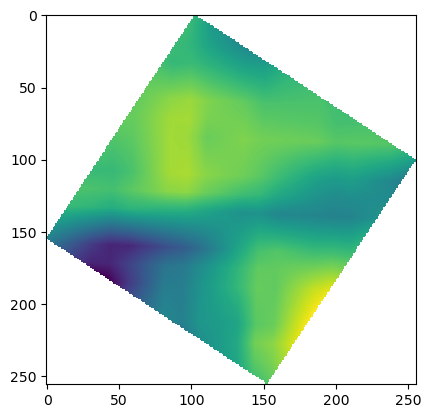

In [8]:
#%% read in what you have downloaded 
import math
# find the ids that matches crops 
idx=np.where(df_soil["LC0_Desc"]=="Cropland")[0]

# get the point ids
crop_ids=np.array(df_soil.iloc[idx]["POINTID"])

#crop_ids=np.array(df_soil["POINTID"])

# match with downloaded images
imgs=glob.glob("ndmi_data/*/sr.tiff",recursive=True)
#%% Extract ID numbers and dates of images
id_numbers = []
date_l=[]

for img_path in imgs:
    # Extract the folder name from the path
    folder_name = os.path.basename(os.path.dirname(img_path))
    
    # Split the folder name by underscore
    parts = folder_name.split('_')
    
    # The ID number is the first part before the underscore
    id_number = parts[0]
    date=parts[1]
    
    # Append the ID number to the list
    id_numbers.append(int(id_number))
    date_l.append(date)

id_numbers=np.array(id_numbers)

#%% match idx and id numbers of the crops
idx=np.where(np.isin(id_numbers,crop_ids))[0]
date_crops_l=np.array(date_l)[idx] # date list
id_crops_l=np.array(id_numbers)[idx] # id number list
img_crops_l1=np.array(imgs)[idx] # list of images based on id number

#%% plot your results to see what you have downloaded 
import tifffile as tiff

test=tiff.imread(imgs[20])

# plot what you have found
plt.imshow(test)


#%%
import tifffile as tiff
min_l=[]
max_l=[]
median_l=[]
point_id_l=[]
mean_l=[]
date_l=[]



for i in range(0,len(img_crops_l1)):
    test=tiff.imread(img_crops_l1[i])
 
    #test = np.where(test > 0.0, test, np.nan) # this is only relevant for NDVI values
    
    min_value = np.nanmin(test)
    max_value = np.nanmax(test)
    median_value=np.nanmedian(test)
    mean_value=np.nanmean(test)
    std_value=np.nanstd(test)
    pixel_count=np.sum(~np.isnan(test))
    point_id=id_crops_l[i]
    date=date_crops_l[i]
    
    min_l.append(min_value)
    max_l.append(max_value) 
    median_l.append(median_value)
    mean_l.append(mean_value)
    point_id_l.append(point_id)
    date_l.append(date)
    
data = {
    'Min': min_l,
    'Max': max_l,
    'Median': median_l,
    'Mean': mean_l,
    'Point_id': point_id_l,
    'date': date_l
}    
    
df = pd.DataFrame(data)

#%% merge soil dataframe with NDVI frame
idx_l=[]
for i in range(0,len(df["Point_id"])):
    idx=np.where(df["Point_id"][i]==np.array(df_soil["POINTID"]))[0]
    idx_l.append(int(idx))

df_soil_subset=df_soil.iloc[idx_l]


merged_df = pd.merge(df, df_soil_subset, left_on='Point_id', right_on='POINTID')

#%% export CSV
csv_file_path = "lucas_soil_ndmi_new8_postive.csv"

# Write the DataFrame to a CSV file
merged_df.to_csv(csv_file_path, index=False)
